In [1]:
!module load cuda proxy
!nvcc -V
!nvidia-smi
!export CUDA_VISIBLE_DEVICES=7

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
Wed Nov 20 10:09:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:01:00.0 Off |                    0 |
|  0%   57C    P0              87W / 30

In [24]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np

from stacathome import MaxiCube

import rasterio
import segmentation_models_pytorch as smp
import torch
import xarray as xr
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt

from stacathome.cloudmask import CloudMask
# Open each band and read the first (and usually only) layer
def plot_item_rgb(item):
    red_band = rasterio.open(item.assets['B04'].href).read(1)  # Red band (B04)
    green_band = rasterio.open(item.assets['B03'].href).read(1)  # Green band (B03)
    blue_band = rasterio.open(item.assets['B02'].href).read(1)  # Blue band (B02)

    # Stack bands along the third axis to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Normalize the bands to the range [0, 1] if needed (depends on data range)
    rgb_image = rgb_image / rgb_image.max()

    # Display the RGB image
    plt.imshow(rgb_image)
    #plt.axis('off')  # Hide axes


In [25]:
aoi = 'somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 0.00018  # 20  # 0.00018
crs = 4326  # 32737  # 4326
chunksize_xy = 256
chunksize_t = 1000

out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr'

mxc = MaxiCube(aoi=aoi,
               requested_bands=requested_bands,
               crs=crs,
               resolution=resolution,
               chunksize_xy=chunksize_xy,
               chunksize_t=chunksize_t,
               path=out_path,
               zarr_path=zarr_store,
               )

Loading local assets
Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.


In [4]:
# set visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# select visible device in torch

device = torch.cuda.device(7)

In [26]:
import rasterio
import stackstac as ss
import itertools
import dask
from dask.distributed import Client as daskClient, get_worker

def setup_cloud_mask_model(device, bands):
    from stacathome.cloudmask import CloudMask
    return CloudMask(device=device, bands=bands)

def prior_check_cloud_mask(item, bands=['B02', 'B03', 'B04', 'B8A']):
    if not set(bands).issubset(set(item.assets.keys())): 
        return False, 'missing bands'
    
    path_out = item.assets[bands[0]].href[:-11] + 'MSK' + item.assets[bands[0]].href[-8:]

    if os.path.exists(path_out):
        return False, 'exists'
    return True, 'do'

def process_mask(item, bands, cm, height=10980, width=10980, divide_image_by=2):
    stack = ss.stack(item, assets=bands)
    full_mask = np.zeros((1, height, width), dtype=np.uint8)
    y_intervals = list(range(0, height+1, height//divide_image_by))
    x_intervals = list(range(0, width+1, width//divide_image_by))
    for y, x in itertools.product(range(len(y_intervals) - 1), range(len(x_intervals) - 1)):
        future_tile = cm(stack.isel(y=slice(y_intervals[y], y_intervals[y+1]), x=slice(x_intervals[x], x_intervals[x+1])))
        full_mask[:, y_intervals[y]:y_intervals[y+1], 
                    x_intervals[x]: x_intervals[x+1]] = future_tile.astype('uint8')
    return full_mask


def process_tile(cm, stack, y_start, y_end, x_start, x_end):
    """Process each tile by applying the cloud mask."""
    return cm(stack.isel(y=slice(y_start, y_end), x=slice(x_start, x_end)))


def run_cloud_mask(item, device='cuda', bands=['B02', 'B03', 'B04', 'B8A'], divide_image_by=2):
    cm = setup_cloud_mask_model(device, bands)
        
    path_out = item.assets[bands[0]].href[:-11] + 'MSK' + item.assets[bands[0]].href[-8:]        

    with rasterio.open(item.assets['B02'].href) as src:
        original_meta = src.meta.copy()

    full_mask = process_mask(item, bands, cm, original_meta['height'], original_meta['width'], divide_image_by=divide_image_by)

    original_meta.update({
        "count": full_mask.shape[0],  # Number of bands
        "height": full_mask.shape[1],  # Rows
        "width": full_mask.shape[2],   # Columns
        "dtype": full_mask.dtype.name  # Data type (e.g., 'uint8', 'float32')
    })

    # Write the array to disk using the original metadata
    with rasterio.open(path_out, "w", **original_meta) as dest:
        dest.write(full_mask)  # Write all bands at once if `array` is 3D (bands, height, width)

    item.assets['MSK'] = item.assets['B02']
    item.assets['MSK'].href = path_out

    
    return (item, 'done')

In [6]:
torch.cuda.empty_cache()

In [7]:
import dask
from dask.distributed import Client as daskClient
from dask_jobqueue import SLURMCluster

In [12]:
cluster = SLURMCluster(
    queue='gpu',
    cores=1,
    processes=1,
    memory='16GB',
    walltime='01:30:00',
    job_extra_directives=['--gres=gpu:A40:1'],
    job_script_prologue=[
        'module load BGC-easybuilded',
        'module load  GCC',
    ]
    
)
cluster.scale(4)
client = daskClient(cluster)
cluster

/Net/Groups/BGI/scratch/mzehner/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46241 instead
  warnings.warn(


Dashboard: http://10.0.30.41:46241/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.41:40949,Workers: 0
Dashboard: http://10.0.30.41:46241/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
client.wait_for_workers(n_workers=2) 

In [27]:
from tqdm import tqdm

futures = []
items = []
bands = ['B02', 'B03', 'B04', 'B8A']#
iterations =0
for i in tqdm(mxc.items_local_global[:1000]):
    if prior_check_cloud_mask(i)[0]:
        break


    
        # futures.append(dask.delayed(run_cloud_mask)(i))
        #run_cloud_mask(items)

        iterations += 1
    if iterations == 20:
        break
        # update the items!
#print(len(tasks))

 62%|██████▏   | 618/1000 [00:00<00:00, 3759.45it/s]


In [28]:
i

<Item id=S2B_MSIL2A_20230901T070629_R106_T38PRR_20230901T141421>

In [89]:
from datetime import datetime, timezone

data_bands = np.zeros((4, 10980, 10980), dtype=np.float32)
offset = 0
if i.datetime > datetime(2022, 1, 25, tzinfo=timezone.utc):
    offset = 1000
for b in bands:
    if b == 'B8A':
        band_int = np.repeat(
            np.repeat(
                rasterio.open(i.assets[b].href).read(1), 2, axis=0), 2, axis=1)
        band_int - offset
        # correcting the underflow
        band_int[band_int >= 64536] = 0
    else:
        band_int = rasterio.open(i.assets[b].href).read(1)

    # ajdust baselinechange in S--2 after jan 2022
    if i.datetime > datetime(2022, 1, 25, tzinfo=timezone.utc):
        band_int = band_int - 1000
        # correcting the underflow
        band_int[band_int >= 64536] = 0

    data_bands[bands.index(b)] = band_int# /10000

    #data_bands[data_bands == 0] = 1.0

In [90]:

np.iinfo(band_int.dtype).max

65535

In [91]:
data_bands_stack = data_bands.reshape(4, 2, data_bands.shape[1]//2, 2, data_bands.shape[2]//2)
data_bands_stack = einops.rearrange(data_bands_stack, 'c t1 h t2 w -> (t1 t2) c h w')

In [92]:
data_bands_stack.shape

(4, 4, 5490, 5490)

In [ ]:
np.pad(data_bands_stack, ((0, 0), (0, 0), (1, 1), (1, 1)), mode='constant').shape

In [72]:
2**16

65536

In [73]:
np.max(data_bands[0]), np.min(data_bands[0])


(np.float32(13864.0), np.float32(0.0))

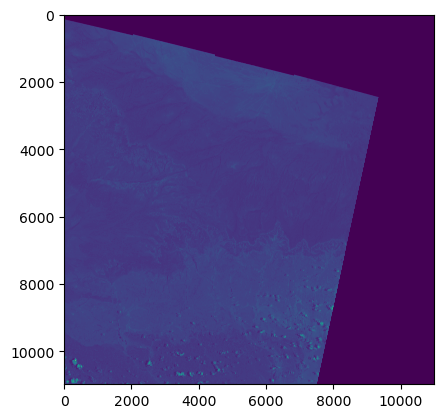

In [74]:
plt.imshow(data_bands[0])

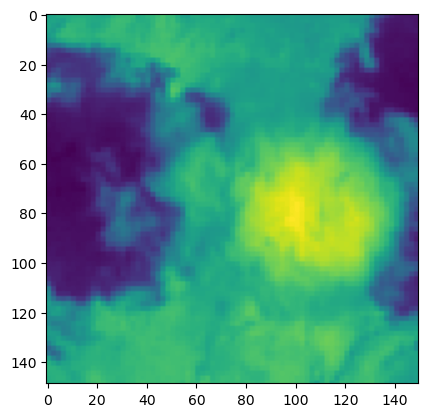

In [75]:
plt.imshow(data_bands[3, -150:-1, 0:150])

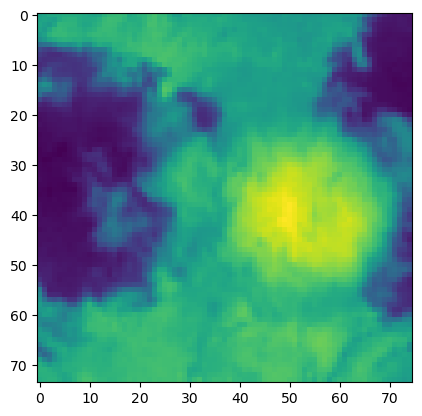

In [76]:
plt.imshow(rasterio.open(i.assets[b].href).read(1)[-75:-1, 0:75])

In [77]:
stack = ss.stack(i, assets=bands)

In [78]:
stack.isel(y=slice(-150,-1), x=slice(0, 150), band=3).values[0].shape, data_bands[3, -150:-1, 0:150].shape

((149, 150), (149, 150))

In [79]:
stack.isel(y=slice(-150,-1), x=slice(0, 150), band=3).values[0], data_bands[3, -150:-1, 0:150]

(array([[6108., 6108., 6191., ..., 2727., 2761., 2761.],
        [6108., 6108., 6191., ..., 2727., 2761., 2761.],
        [6171., 6171., 6219., ..., 2754., 2681., 2681.],
        ...,
        [6454., 6454., 6535., ..., 5970., 6038., 6038.],
        [6454., 6454., 6535., ..., 5970., 6038., 6038.],
        [6459., 6459., 6446., ..., 6061., 6096., 6096.]]),
 array([[6108., 6108., 6191., ..., 2727., 2761., 2761.],
        [6108., 6108., 6191., ..., 2727., 2761., 2761.],
        [6171., 6171., 6219., ..., 2754., 2681., 2681.],
        ...,
        [6454., 6454., 6535., ..., 5970., 6038., 6038.],
        [6454., 6454., 6535., ..., 5970., 6038., 6038.],
        [6459., 6459., 6446., ..., 6061., 6096., 6096.]], dtype=float32))

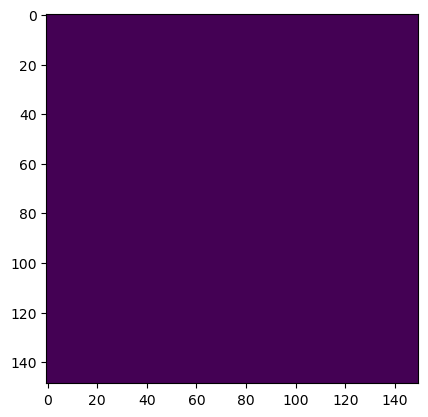

In [81]:
plt.imshow(stack.isel(y=slice(-150,-1), x=slice(0, 150), band=3).values[0] - data_bands[3, -150:-1, 0:150])

In [19]:
fut = dask.compute(*futures)

In [20]:
fut

([(<Item id=S2B_MSIL2A_20231107T070109_R063_T38PRQ_20231107T142227>, 'done'),
  (<Item id=S2A_MSIL2A_20230906T070631_R106_T38PRR_20230906T143520>, 'done'),
  (<Item id=S2A_MSIL2A_20240719T065621_R063_T39PTL_20240719T130050>, 'done'),
  (<Item id=S2A_MSIL2A_20240503T070621_R106_T38PRQ_20240503T121115>, 'done'),
  (<Item id=S2A_MSIL2A_20240413T070621_R106_T39PTL_20240413T115054>, 'done'),
  (<Item id=S2B_MSIL2A_20240405T065619_R063_T38PRR_20240405T122846>, 'done'),
  (<Item id=S2B_MSIL2A_20240309T070719_R106_T39PTK_20240309T111119>, 'done'),
  (<Item id=S2B_MSIL2A_20240228T070829_R106_T39PTK_20240228T111447>, 'done'),
  (<Item id=S2A_MSIL2A_20230205T070101_R063_T38PRQ_20230206T015059>, 'done'),
  (<Item id=S2A_MSIL2A_20220111T070251_R063_T39PTK_20220112T090624>, 'done')],
 [(<Item id=S2B_MSIL2A_20210117T072229_R006_T38PNQ_20210120T020014>, 'done'),
  (<Item id=S2A_MSIL2A_20210116T070231_R063_T38NRM_20210116T214210>, 'done'),
  (<Item id=S2B_MSIL2A_20210107T072259_R006_T38NLF_20210121T094

In [ ]:
futures = client.gather(futures)
# results = []
# for future in futures:
#     result = future.result()  # Retrieve result
#     results.append(result)
#     future.release() 

AttributeError: 'list' object has no attribute 'result'

In [14]:
futures

[[(<Item id=S2A_MSIL2A_20240530T065621_R063_T38PRQ_20240530T131426>, 'done'),
  (<Item id=S2B_MSIL2A_20240528T070619_R106_T39PTK_20240528T134300>, 'done'),
  (<Item id=S2A_MSIL2A_20240430T065621_R063_T39PTL_20240430T122342>, 'done'),
  (<Item id=S2B_MSIL2A_20240408T070619_R106_T38PRR_20240408T111350>, 'done'),
  (<Item id=S2A_MSIL2A_20240403T070621_R106_T39PTL_20240403T121940>, 'done'),
  (<Item id=S2B_MSIL2A_20240326T065619_R063_T38PRR_20240326T132131>, 'done'),
  (<Item id=S2A_MSIL2A_20240311T065701_R063_T38PRQ_20240311T151242>, 'done'),
  (<Item id=S2B_MSIL2A_20240309T070719_R106_T38PRR_20240309T111259>, 'done'),
  (<Item id=S2B_MSIL2A_20240306T065739_R063_T38PRQ_20240306T113321>, 'done'),
  (<Item id=S2A_MSIL2A_20240223T070901_R106_T39PTL_20240223T161553>, 'done')]]

In [46]:
results

[[('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2B_MSIL2A_20240508T070619_N0510_R106_T38PRQ_20240508T110152.SAFE',
   'done'),
  ('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2B_MSIL2A_20240415T065619_N0510_R063_T38PRQ_20240415T102358.SAFE',
   'done'),
  ('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2A_MSIL2A_20210102T072311_N0212_R006_T38NKH_20210102T233326.SAFE',
   'done'),
  ('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2B_MSIL2A_20210101T070309_N0212_R063_T39NTH_20210110T095033.SAFE',
   'done'),
  ('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2A_MSIL2A_20240818T065621_N0511_R063_T38PRR_20240818T122854.SAFE',
   'done')]]

In [40]:
tasks[0].release()

In [35]:
res

[None]

In [27]:
item = mxc.items_local_global[15]
with rasterio.open(item.assets['B02'].href) as src:
    original_meta = src.meta.copy()
bands = ['B02', 'B03', 'B04', 'B8A']
divide_image_by = 2
y_intervals = list(range(0, original_meta['height']+1, original_meta['height']//divide_image_by))
x_intervals = list(range(0, original_meta['width']+1, original_meta['width']//divide_image_by))
stack = ss.stack(item, assets=bands)
# combinations = []
# for y, x in itertools.product(range(len(y_intervals) - 1), range(len(x_intervals) - 1)):
#     combinations.append((y_intervals[y], y_intervals[y+1], x_intervals[x], x_intervals[x+1]))
cm = CloudMask(device='cuda', bands=bands)
tile_results = []
for y_start, y_end, x_start, x_end in itertools.product(y_intervals[:-1], y_intervals[1:], x_intervals[:-1], x_intervals[1:]):
    print(y_start, y_end, x_start, x_end)
    tile_results.append(process_tile(cm, stack, y_start, y_end, x_start, x_end))

0 5490 0 5490
0 5490 0 10980
0 5490 5490 5490


RuntimeError: Expected 3D or 4D (batch mode) tensor with possibly 0 batch size and other non-zero dimensions for input, but got: [1, 4, 5490, 0]

In [19]:
tasks[0]

Delayed('run_cloud_mask-fc656e35-6b63-4d2e-a2ba-70ce0e6d736a')

In [20]:
res = dask.compute(tasks[0])

In [21]:
client.close()
cluster.close()

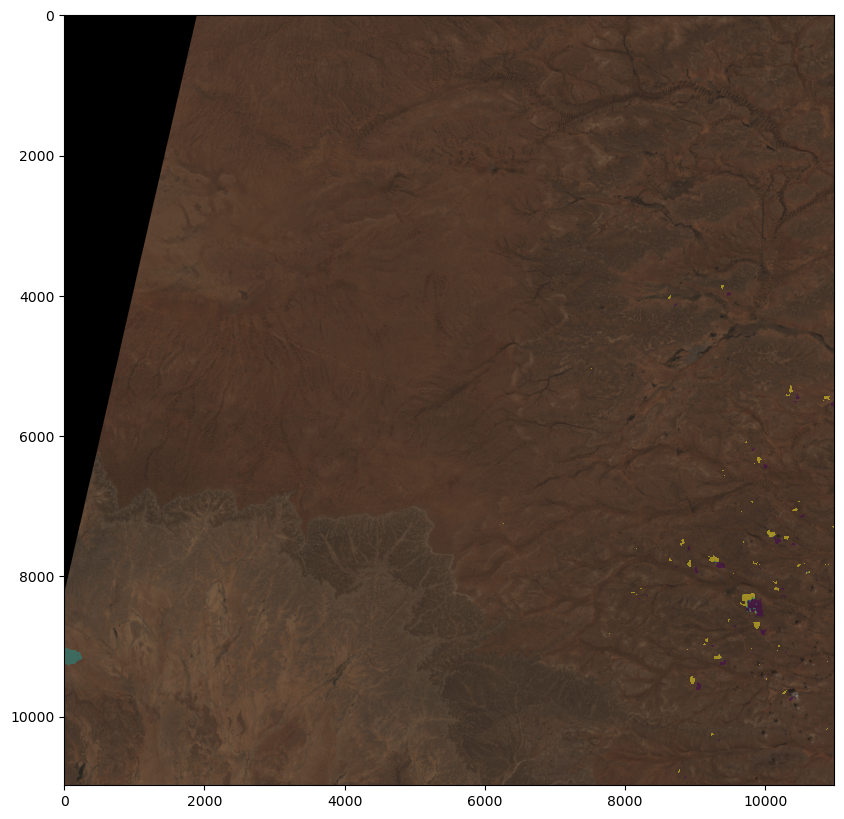

In [120]:
item = mxc.items_local_global[15]
path_out = item.assets[bands[0]].href[:-11] + 'MSK' + item.assets[bands[0]].href[-8:]

mask = rasterio.open(path_out).read()[0]
mask = mask.astype('float32')
mask[mask == 0.] = np.nan

plt.figure(figsize=(10,10))
plot_item_rgb(item)
plt.imshow(mask, alpha=0.5)


In [62]:
rasterio(masked.astype('uint8')).profile

TypeError: 'module' object is not callable

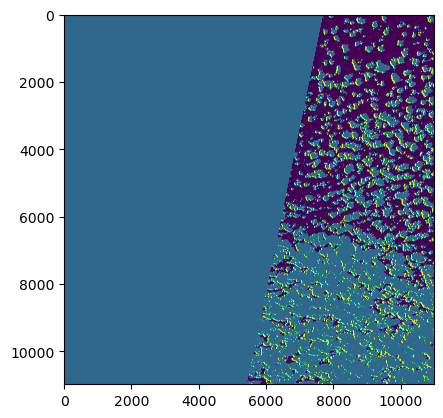

In [50]:
plt.imshow(masked.astype('uint8'))

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mask = np.load('/Net/Groups/BGI/scratch/mzehner/code/stacathome/mask.npy', allow_pickle=True)

In [3]:
mask.shape

(4, 5504, 5504)

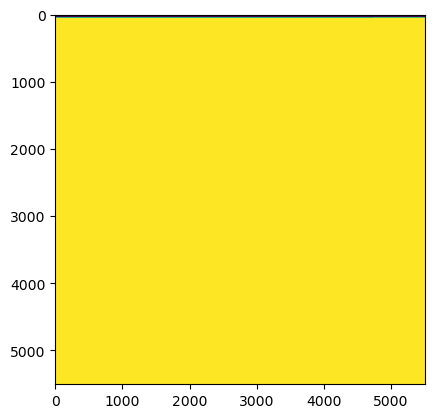

In [8]:
plt.imshow(mask[0])

In [21]:
import einops

In [22]:
maskr = einops.rearrange(mask, '(t1 t2) h w -> t1 h t2 w', t1=2)
maskr = maskr.reshape(1, 5504*2, 5504*2)

maskr = maskr.astype(np.uint8)

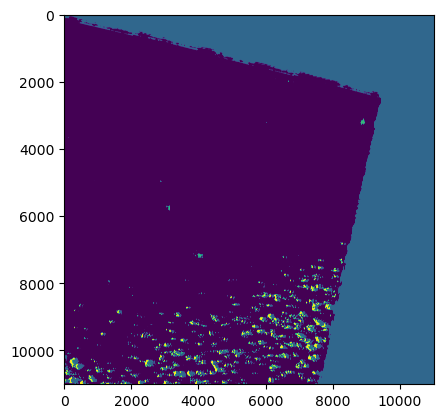

In [23]:
plt.imshow(maskr[0])

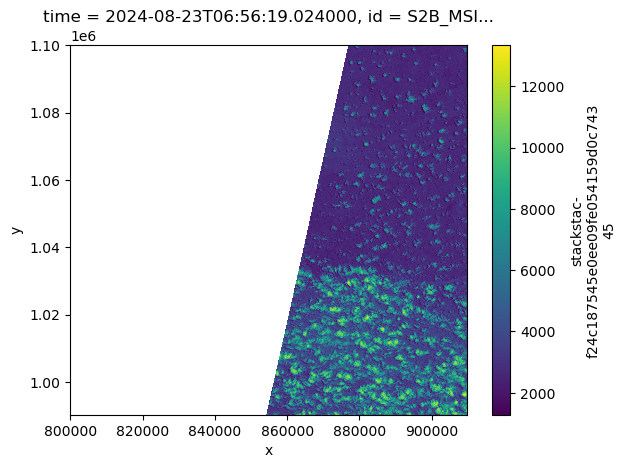

In [19]:
ss.stack(mxc.items_local_global[0]).isel(band=0).plot()

In [76]:
mxc.items_local_global[0].assets['MSK'] = mxc.items_local_global[0].assets['B02']

In [78]:
mxc.items_local_global[0]


<Item id=S2B_MSIL2A_20240823T065619_R063_T38PRR_20240823T113539>

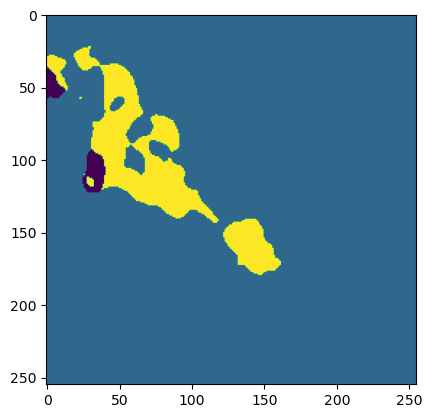

In [57]:
plt.imshow(masked.values[4][0])

In [11]:
import rasterio


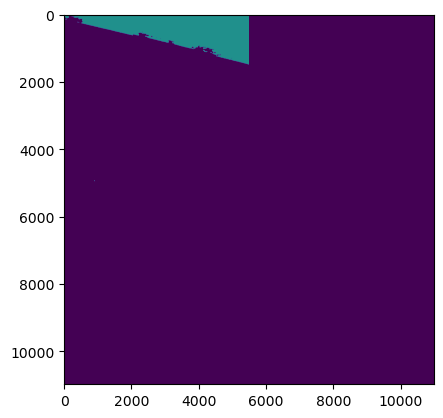

In [52]:

mask = rasterio.open('mask_test_tile0.tif').read()[0]
plt.imshow(mask)

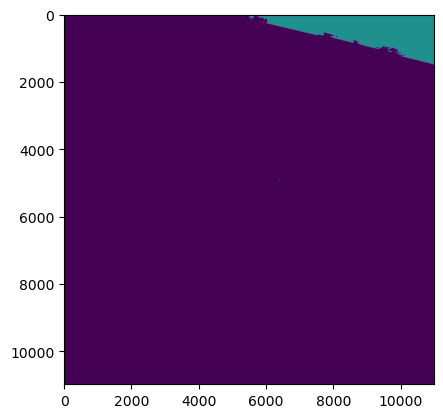

In [53]:

mask = rasterio.open('mask_test_tile1.tif').read()[0]
plt.imshow(mask)

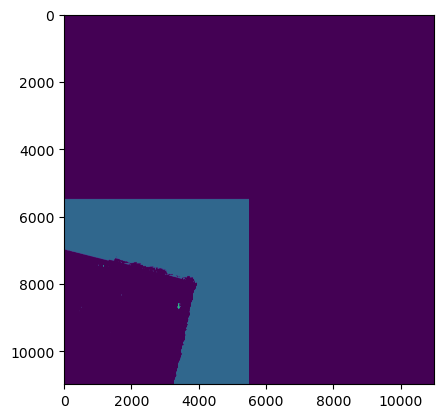

In [54]:
mask = rasterio.open('mask_test_tile2.tif').read()[0]
plt.imshow(mask)

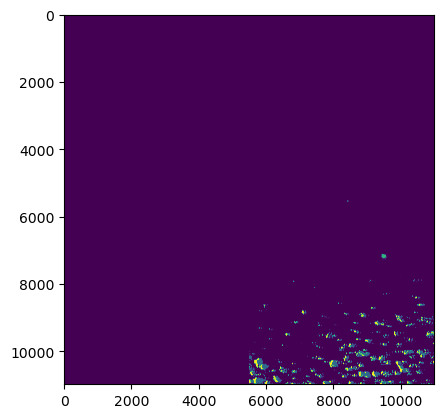

In [55]:
mask = rasterio.open('mask_test_tile3.tif').read()[0]
plt.imshow(mask)

In [46]:
mask.dtype.name

'uint8'

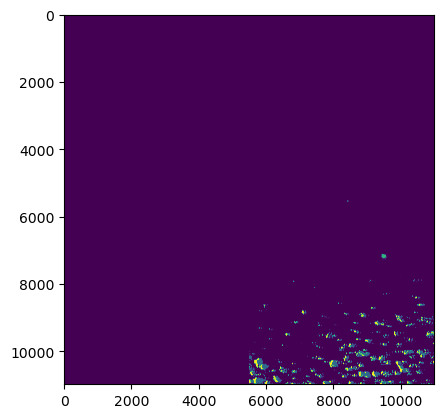

In [47]:
plt.imshow(mask)

In [28]:
rasterio.open('mask_test_split.tif').profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32638), 'transform': Affine(10.0, 0.0, 799980.0,
       0.0, -10.0, 1100040.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}